In [1]:
import h5py
import torch
import numpy as np

torch_rng = torch.manual_seed(777)

DATAFOLDER = "C:/Data"

train_hdf = h5py.File(f"{DATAFOLDER}/simpleserial-aes-fix-500000-diff-profile.hdf5")
val_test_hdf = h5py.File(f"{DATAFOLDER}/simpleserial-aes-fix-500-diff.hdf5")

train_traces = torch.Tensor(np.array(train_hdf['trace']))
train_plaintexts = torch.Tensor(np.array(train_hdf['data']))
train_keys = torch.Tensor(np.array(train_hdf['key']))

val_test_traces = torch.Tensor(np.array(val_test_hdf['trace']))
val_test_plaintexts = torch.Tensor(np.array(val_test_hdf['data']))
val_test_keys = torch.Tensor(np.array(val_test_hdf['key']))

In [2]:
s_box = [
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16,
]

In [4]:
train_sbox_output = torch.empty((500000,2,16))
ark_output = torch.empty((500000,2,16))
val_test_sbox_output = torch.empty((1000,500,2,16))

for idx, (key, plaintext) in enumerate(zip(train_keys, train_plaintexts)):

    pt = plaintext.clone()
    block1 = pt[:16]
    block2 = pt[16:]

    block1.map_(key, lambda x,y: s_box[int(x) ^ int(y)])
    block2.map_(key, lambda x,y: s_box[int(x) ^ int(y)])

    block1, block2 = block1.long(), block2.long()

    train_sbox_output[idx, 0] = block1
    train_sbox_output[idx, 1] = block2

    pt = plaintext.clone()
    block1 = pt[:16]
    block2 = pt[16:]

    block1.map_(key, lambda x,y: int(x) ^ int(y))
    block2.map_(key, lambda x,y: int(x) ^ int(y))

    ark_output[idx, 0] = block1
    ark_output[idx, 1] = block2

# Outer loop is each of only 1000 different keys in testing set
for key_idx in range(val_test_traces.shape[0]):
    for idx, (key, plaintext) in enumerate(zip(val_test_keys[key_idx], val_test_plaintexts[key_idx])):

        pt = plaintext.clone()
        block1 = pt[:16]
        block2 = pt[16:]

        block1.map_(key, lambda x,y: s_box[int(x) ^ int(y)])
        block2.map_(key, lambda x,y: s_box[int(x) ^ int(y)])

        block1,block2 = block1.long(),block2.long()

        val_test_sbox_output[key_idx, idx, 0] = block1
        val_test_sbox_output[key_idx, idx, 1] = block2


In [6]:
import matplotlib.pyplot as plt
from scalib.metrics import SNR

BYTE = 1
TRACE_START = 0
TRACE_END = 1000

traces = train_traces[:, 0:1000].numpy().astype(np.int16)

# scalib requires last dimension to not be squeezed
sbox1 = train_sbox_output[:, 0, BYTE:BYTE+1].numpy().astype(np.uint16)
sbox2 = train_sbox_output[:, 1, BYTE:BYTE+1].numpy().astype(np.uint16)

ark1 = ark_output[:, 0, BYTE:BYTE+1].numpy().astype(np.uint16)
ark2 = ark_output[:, 1, BYTE:BYTE+1].numpy().astype(np.uint16)

key1 = train_keys[:, BYTE:BYTE+1].numpy().astype(np.uint16)

In [7]:
snr = SNR(nc=256)

snr.fit_u(traces, sbox1)

sbox1_snr_val = snr.get_snr()[0]

In [8]:
snr.fit_u(traces, sbox2)

sbox2_snr_val = snr.get_snr()[0]

In [9]:
snr.fit_u(traces, ark1)

ark1_snr_val = snr.get_snr()[0]

snr.fit_u(traces, ark2)

ark2_snr_val = snr.get_snr()[0]

In [10]:
snr.fit_u(traces, key1)

key_snr_val = snr.get_snr()[0]

In [49]:
import json

MODELS_FOLDER = "E:/Master/Avhandling/Models/models"

IMPL = "fixslice"
TARGET = "sbox"
BYTE = 1
ARCH = "zhang"
TRACE_START = 0
TRACE_END = 1000

MODEL_NAME = f"{IMPL}-{TARGET}-byte{BYTE}-{ARCH}-{TRACE_START}_{TRACE_END}"

with open(f"{MODELS_FOLDER}/lrp/{MODEL_NAME}.json", 'r') as f:
    attr_info1 = json.load(f)


In [50]:
IMPL = "fixslice"
TARGET = "sbox2"
BYTE = 1
ARCH = "zhang"
TRACE_START = 0
TRACE_END = 1000

MODEL_NAME = f"{IMPL}-{TARGET}-byte{BYTE}-{ARCH}-{TRACE_START}_{TRACE_END}"

with open(f"{MODELS_FOLDER}/lrp/{MODEL_NAME}.json", 'r') as f:
    attr_info2 = json.load(f)


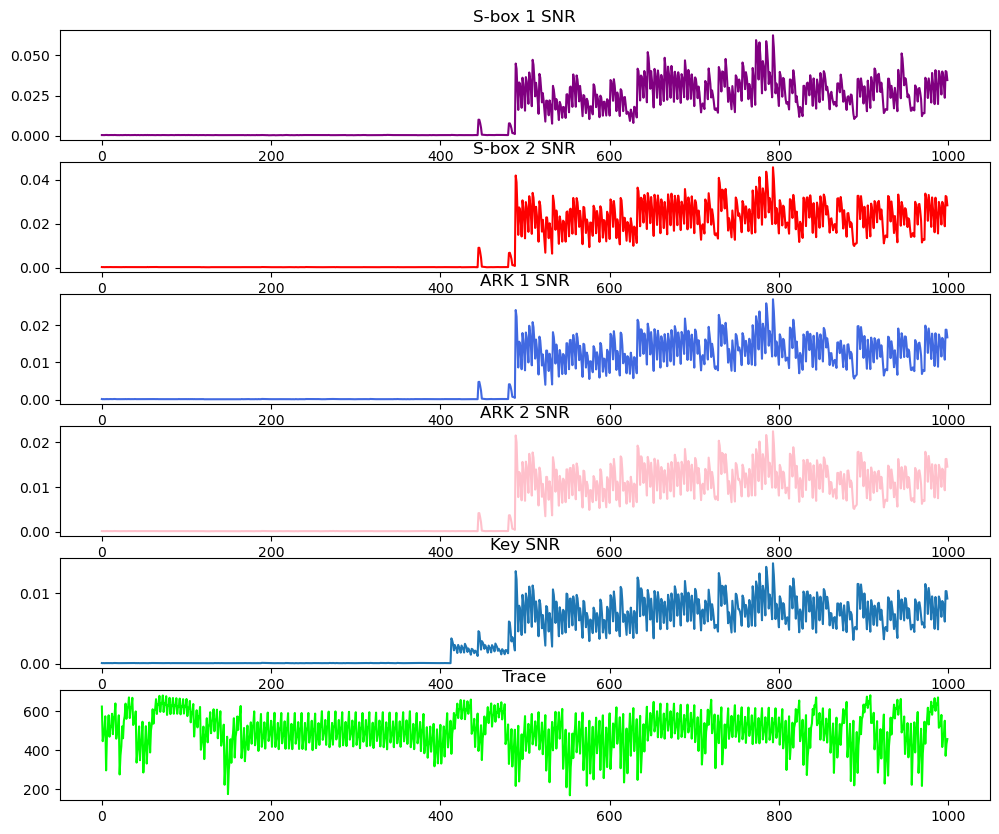

: 

In [ ]:
trace = traces[44321]

fig, axs = plt.subplots(nrows=6, ncols=1)
fig.set_figheight(10.0)
fig.set_figwidth(12.0)

axs[0].plot(sbox1_snr_val, 'purple')
axs[1].plot(sbox2_snr_val, 'red')
axs[2].plot(ark1_snr_val, 'royalblue')
axs[3].plot(ark2_snr_val, 'pink')
axs[4].plot(key_snr_val)
axs[5].plot(trace[0:1000], 'lime')

axs[0].set_title("S-box 1 SNR")
axs[1].set_title("S-box 2 SNR")
axs[2].set_title("ARK 1 SNR")
axs[3].set_title("ARK 2 SNR")
axs[4].set_title("Key SNR")
axs[5].set_title("Trace")

plt.show()